<p style="font-size:22px; font-weight:bold;">Here, we perform XGBoost on the dataset "All Data Imported.csv", with GridSearchCV strategy to find the optimum hyperparameters.</p>  

Fitting 4 folds for each of 729 candidates, totalling 2916 fits


c:\Users\AhmedFahmy\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:54:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.8}

Cross-validation F1 scores: [0.62203765 0.6258098  0.62908956 0.63507981]
Mean CV score: 0.6280

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.61      0.23      0.34       554
          FM       0.81      0.92      0.86      6404
         FiM       0.64      0.29      0.40       865
          NM       0.97      0.96      0.96     10031

    accuracy                           0.89     17854
   macro avg       0.76      0.60      0.64     17854
weighted avg       0.88      0.89      0.88     17854



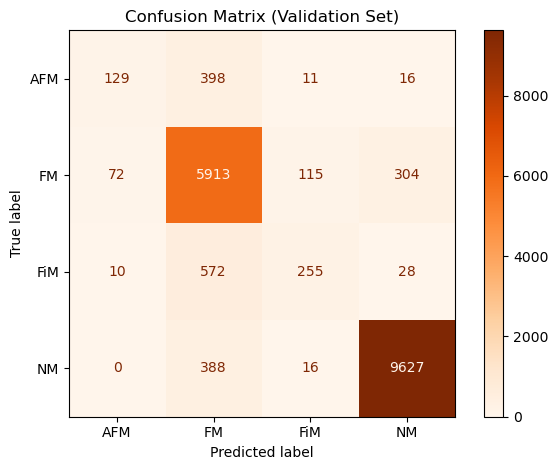


🧪 Test Classification Report:
              precision    recall  f1-score   support

         AFM       0.57      0.21      0.31       554
          FM       0.81      0.92      0.86      6405
         FiM       0.66      0.31      0.42       865
          NM       0.96      0.96      0.96     10030

    accuracy                           0.89     17854
   macro avg       0.75      0.60      0.64     17854
weighted avg       0.88      0.89      0.88     17854



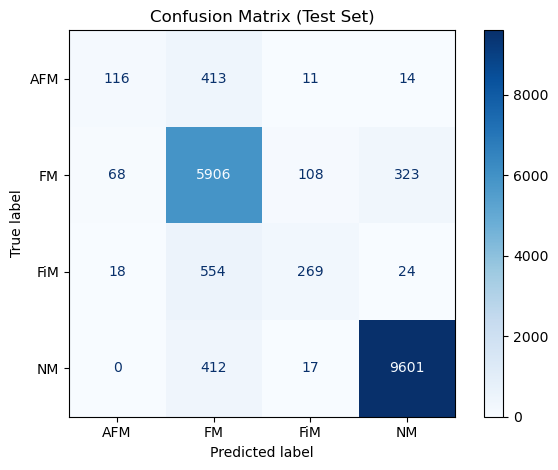

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Load CSV file
df = pd.read_csv("All Data Imported.csv")

# Parse elements column 
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# Extract crystal system from symmetry column
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# Drop rows with missing essential features 
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements 
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# One-hot encode crystal system 
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# Encode target 
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# Split: 80% (train+val) and 20% (test) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

#  Split 80% into 60% (train) and 20% (val) ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

#  Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(
    XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

#  Fit on training set 
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

#  Cross-validation scores on training set 
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# Evaluate on validation set 
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# Final evaluation on test set 
print("\n🧪 Test Classification Report:")
y_pred_test = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


<p style="font-size:22px; font-weight:bold;">Performance of XGBoost is higher on the NM and FM classes, and slightly lower on FiM and AFM.</p>  

<p style="font-size:22px; font-weight:bold;">Ignore performnce on test set above. The performance on the Validation set is showing good performance on this set of unseen data during training.</p>  

Fitting 4 folds for each of 3 candidates, totalling 12 fits


c:\Users\AhmedFahmy\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:20:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.8}

Cross-validation F1 scores: [0.62203765 0.6258098  0.62908956 0.63507981]
Mean CV score: 0.6280

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.61      0.23      0.34       554
          FM       0.81      0.92      0.86      6404
         FiM       0.64      0.29      0.40       865
          NM       0.97      0.96      0.96     10031

    accuracy                           0.89     17854
   macro avg       0.76      0.60      0.64     17854
weighted avg       0.88      0.89      0.88     17854



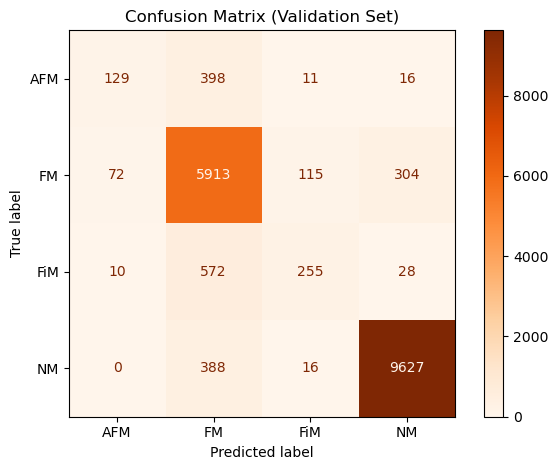

In [ ]:
#Reproduce the above code with the best hyperparameters found in the grid search.
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# === 1. Load CSV ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements column ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split: 80% (train+val) and 20% (test) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. Split 80% into 60% (train) and 20% (val) ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [1.0],
    'reg_lambda': [1.0]
}

grid_search = GridSearchCV(
    XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 12. Fit on training set ===
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores on training set ===
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 14. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()




<p style="font-size:22px; font-weight:bold;">Learning curve check: Checking overfitting.</p>  

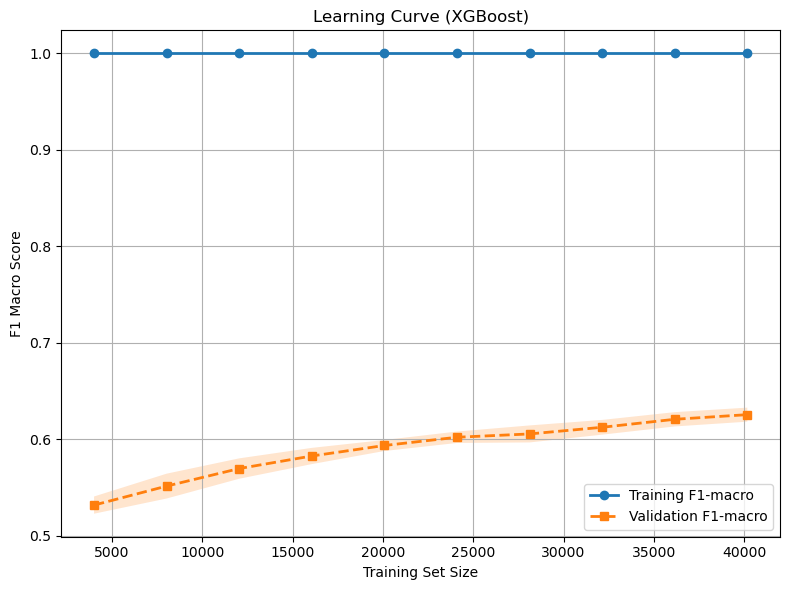

In [2]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# === Use the best model found from GridSearch ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_clf,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# === Compute mean and std ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# === Plot learning curve ===
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training F1-macro", linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, 's--', label="Validation F1-macro", linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Learning Curve (XGBoost)")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


<p style="font-size:22px; font-weight:bold;">result: XGBoost performs good enough on the cross-validation set and becomes better with more training data, which is a sign on not overfitting.</p>  

<p style="font-size:22px; font-weight:bold;">which features were critical in the modelling?</p>  

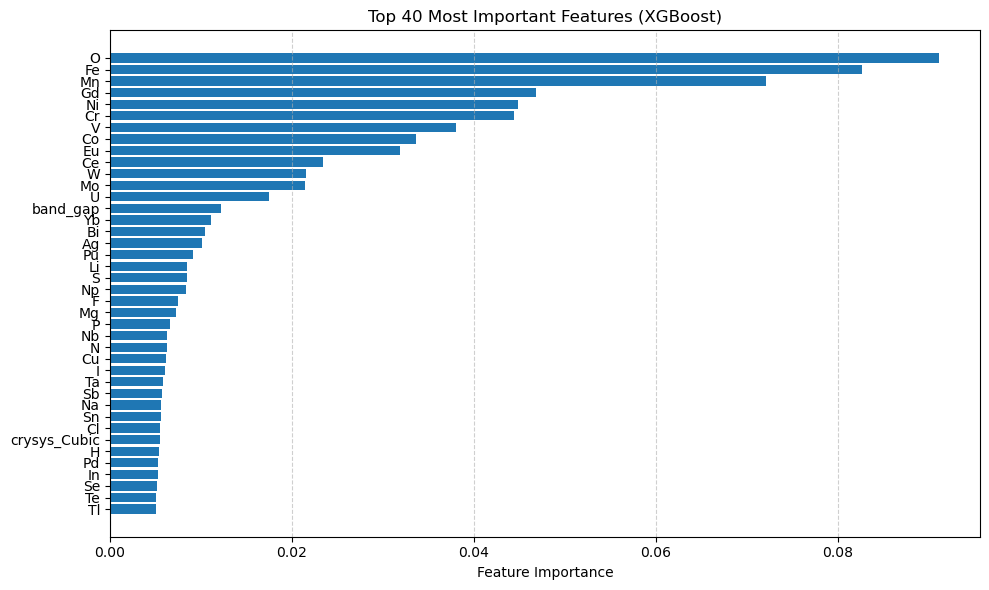

In [4]:
importances = best_clf.feature_importances_
feature_names = X.columns

# === Create a DataFrame for importances ===
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# === Sort by importance ===
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# === Display top features ===
top_n = 40  # change this to display more/less
top_features = importance_df.head(top_n)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Most Important Features (XGBoost)")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


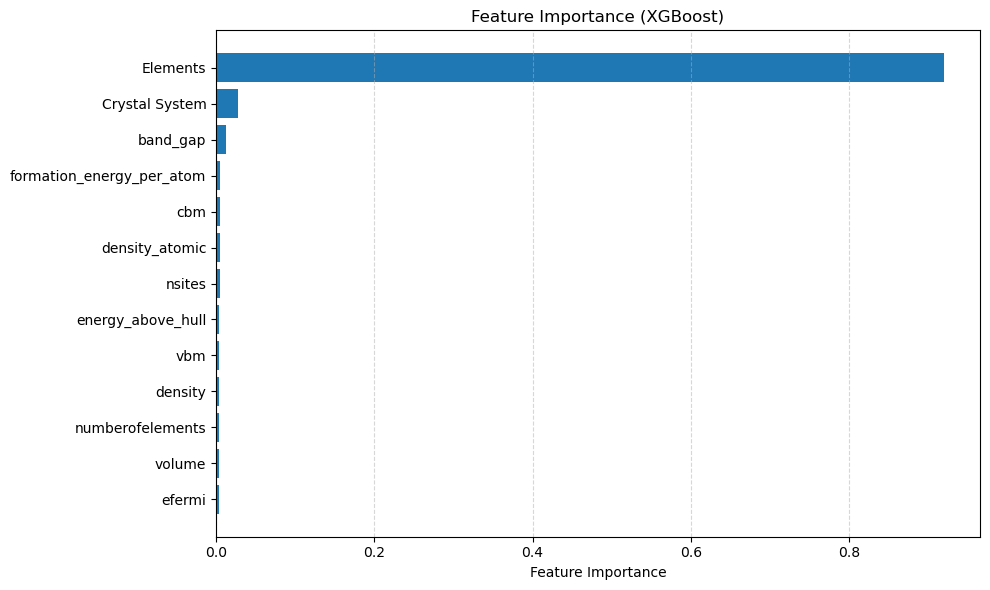

In [7]:
# === Reconstruct the feature groups ===
num_features = df[numerical_features].columns.tolist()
element_features = element_df.columns.tolist()
crysys_features = crystal_df.columns.tolist()

# === Match importances with features ===
importances = best_clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# === Categorize features ===
def categorize_feature(name):
    if name in num_features:
        return name  # keep numerical features expanded
    elif name in element_features:
        return "Elements"
    elif name in crysys_features:
        return "Crystal System"
    else:
        return "Other"

importance_df["Category"] = importance_df["Feature"].apply(categorize_feature)

# === Group and sum ===
grouped_df = importance_df.groupby("Category")["Importance"].sum().reset_index()
grouped_df = grouped_df.sort_values(by="Importance", ascending=False)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(grouped_df["Category"][::-1], grouped_df["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


<p style="font-size:22px; font-weight:bold;">result: Elements is the most critical feature, with the Crystal System in second place.</p> 